# Matching q(z), z:=v/|v|*g, g~NF to p=Normal by minimizing KL(q|p)

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
%pip install -q torch

Note: you may need to restart the kernel to use updated packages.


In [30]:
import torch

from torch.distributions import MultivariateNormal


In [31]:
torch.__version__

'1.12.1'

In [32]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    ENV = torch.cuda
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    ENV = torch
    print("Using CPU")

Using CPU


In [33]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5) # Width and height

In [34]:
import sys
sys.path.append("../")

In [35]:
from reparametrized import sampling

## Sanity check our implementation of weight_norm  

In [36]:
from torch import nn, _weight_norm
from torch.nn.utils import weight_norm
from reparametrized.sampling.bayesian_hypernets import _weight_norm_our

One sample:

In [37]:
# m = weight_norm(nn.Conv3d(11, 5, (7,3,2)), name="weight")
m = weight_norm(nn.Linear(11, 5), name="weight")

v = m.weight_v
g = m.weight_g
print(m.weight.shape, g.shape, v.shape)

(_weight_norm(v,g,dim=0)-m.weight).max(), (_weight_norm_our(v,g,dim=0)-m.weight).max()

torch.Size([5, 11]) torch.Size([5, 1]) torch.Size([5, 11])


(tensor(0., grad_fn=<MaxBackward1>),
 tensor(2.9802e-08, grad_fn=<MaxBackward1>))

Multiple samples:

In [38]:
ms, vs, gs = [], [], []
for _ in range(17):
    m = weight_norm(nn.Linear(11, 5), name="weight")
    # m = weight_norm(nn.Conv3d(11, 5, (7,3,2)), name="weight")
    
    v, g = m.weight_v,  m.weight_g
    
    ms.append(m.weight)
    vs.append(v)
    gs.append(g)
ms = torch.stack(ms)
vs = torch.stack(vs)
gs = torch.stack(gs)

(_weight_norm_our(vs, gs, dim=1)-ms).max()

tensor(4.4703e-08, grad_fn=<MaxBackward1>)

## Dimensionality

In [39]:
parameter_shape = (2, 3)  # for Bayesian hypernets parameters dimensionality must be >=2D

# some samplers initialize with this value; others just match its shape
parameter_init_value = torch.randn(torch.Size(parameter_shape))  

## Create target p

In [40]:
## Some full-rank Gaussian:
# t = torch.tensor(range(parameter_shape[0]))*3.
# cov = t[None,:]*t[:,None]+300*torch.eye(parameter_shape[0])
# for i, j in [(1, 3), (5, 3)]:
#     cov[i, j] = -cov[i, j]
#     cov[j, i] = -cov[j, i]
# loc = torch.tensor(range(parameter_shape[0], 0, -1))*2.

In [41]:
# Factorized Gaussian:
loc = torch.zeros(parameter_init_value.numel())
cov = torch.eye(parameter_init_value.numel())

In [42]:
# target
loc, cov

(tensor([0., 0., 0., 0., 0., 0.]),
 tensor([[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.]]))

In [43]:
p = MultivariateNormal(loc=loc, covariance_matrix=cov)

def calc_p_nll(samples):
    samples = samples.flatten(start_dim=1)
    return -p.log_prob(samples)

## Create q

In [44]:
sampler, variational_params, aux_objs = sampling.create_bayesian_hypernet_sampler(parameter_init_value, 
                                                                     realnvp_m=8,  # change default parameters!
                                                                     realnvp_num_layers=16,
                                                                     rezero_trick=True,
                                                                     only_flow_nll=False,
                                                                     )

In [45]:
# Preview variational parameters:
{n: p.shape for n, p in variational_params.items()}

{'alpha': torch.Size([16]),
 'beta': torch.Size([16]),
 't.0.0.weight': torch.Size([8, 1]),
 't.0.0.bias': torch.Size([8]),
 't.0.2.weight': torch.Size([8, 8]),
 't.0.2.bias': torch.Size([8]),
 't.0.4.weight': torch.Size([1, 8]),
 't.0.4.bias': torch.Size([1]),
 't.1.0.weight': torch.Size([8, 1]),
 't.1.0.bias': torch.Size([8]),
 't.1.2.weight': torch.Size([8, 8]),
 't.1.2.bias': torch.Size([8]),
 't.1.4.weight': torch.Size([1, 8]),
 't.1.4.bias': torch.Size([1]),
 't.2.0.weight': torch.Size([8, 1]),
 't.2.0.bias': torch.Size([8]),
 't.2.2.weight': torch.Size([8, 8]),
 't.2.2.bias': torch.Size([8]),
 't.2.4.weight': torch.Size([1, 8]),
 't.2.4.bias': torch.Size([1]),
 't.3.0.weight': torch.Size([8, 1]),
 't.3.0.bias': torch.Size([8]),
 't.3.2.weight': torch.Size([8, 8]),
 't.3.2.bias': torch.Size([8]),
 't.3.4.weight': torch.Size([1, 8]),
 't.3.4.bias': torch.Size([1]),
 't.4.0.weight': torch.Size([8, 1]),
 't.4.0.bias': torch.Size([8]),
 't.4.2.weight': torch.Size([8, 8]),
 't.4.2.bia

## Preview before optimization

In [46]:
samples, nlls = sampler(n_samples=10240)
samples.shape, nlls.shape

(torch.Size([10240, 2, 3]), torch.Size([10240]))

In [47]:
# Means, variances, covariance matrix:
samples.mean(0), samples.std(0)**2, torch.cov(samples.flatten(start_dim=1).T).round(decimals=1)

(tensor([[-0.0121,  0.0069,  0.0154],
         [-0.0028,  0.0031,  0.0062]], grad_fn=<MeanBackward1>),
 tensor([[0.3379, 0.1095, 0.5542],
         [0.1432, 0.1756, 0.6981]], grad_fn=<PowBackward0>),
 tensor([[ 0.3000, -0.2000, -0.4000,  0.0000, -0.0000, -0.0000],
         [-0.2000,  0.1000,  0.2000, -0.0000,  0.0000,  0.0000],
         [-0.4000,  0.2000,  0.6000, -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  0.1000, -0.2000, -0.3000],
         [-0.0000,  0.0000,  0.0000, -0.2000,  0.2000,  0.4000],
         [-0.0000,  0.0000,  0.0000, -0.3000,  0.4000,  0.7000]],
        grad_fn=<RoundBackward1>))

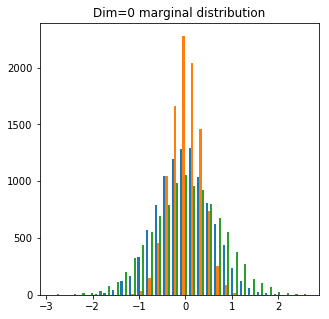

In [48]:
plt.hist(samples[:,0].cpu().detach().numpy(), bins=30);
plt.title("Dim=0 marginal distribution");

## Optimize

In [49]:
optimized_parameters = variational_params.values()
optimizer = torch.optim.Adam(optimized_parameters, lr=0.001) 
n_epochs = 5000
n_posterior_samples = 1

for e in range(n_epochs):
    optimizer.zero_grad()

    samples, q_nlls = sampler(n_samples=n_posterior_samples)
    p_nlls = calc_p_nll(samples)
    KLD = p_nlls-q_nlls

    loss_vi = KLD.mean()
    loss_vi.backward()
    optimizer.step()

    if (e<100 and e%10==0) or e%500==0:
        samples, q_nlls = sampler(n_samples=10240)  # let use  more samples to estimate reported KLD
        p_nlls = calc_p_nll(samples)
        KLD = p_nlls-q_nlls

        print(f"epoch={e}: loss={KLD.mean(): .2f}")

epoch=0: loss= 7.66
epoch=10: loss= 7.58
epoch=20: loss= 7.51
epoch=30: loss= 7.44
epoch=40: loss= 7.39
epoch=50: loss= 7.33
epoch=60: loss= 7.29
epoch=70: loss= 7.25
epoch=80: loss= 7.22
epoch=90: loss= 7.19
epoch=500: loss= 6.97
epoch=1000: loss= 6.97
epoch=1500: loss= 6.98
epoch=2000: loss= 6.97
epoch=2500: loss= 6.97
epoch=3000: loss= 6.97
epoch=3500: loss= 6.97
epoch=4000: loss= 6.97
epoch=4500: loss= 6.97


## Preview after optimization

In [50]:
samples, nlls = sampler(n_samples=102400)

# Means, variances, covariance matrix:
samples.mean(0), samples.std(0)**2, torch.cov(samples.flatten(start_dim=1).T).round(decimals=1)

(tensor([[ 0.0032, -0.0032, -0.0032],
         [ 0.0007, -0.0007, -0.0007]], grad_fn=<MeanBackward1>),
 tensor([[0.3308, 0.3308, 0.3308],
         [0.3299, 0.3299, 0.3299]], grad_fn=<PowBackward0>),
 tensor([[ 0.3000, -0.3000, -0.3000,  0.0000, -0.0000, -0.0000],
         [-0.3000,  0.3000,  0.3000, -0.0000,  0.0000,  0.0000],
         [-0.3000,  0.3000,  0.3000, -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  0.3000, -0.3000, -0.3000],
         [-0.0000,  0.0000,  0.0000, -0.3000,  0.3000,  0.3000],
         [-0.0000,  0.0000,  0.0000, -0.3000,  0.3000,  0.3000]],
        grad_fn=<RoundBackward1>))

In [51]:
# target:
loc, cov 

(tensor([0., 0., 0., 0., 0., 0.]),
 tensor([[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.]]))

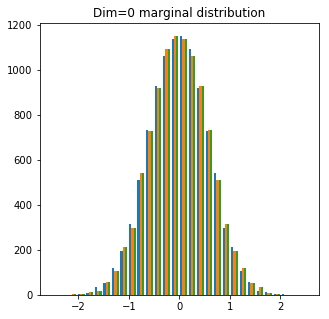

In [52]:
samples, nlls = sampler(n_samples=10240)
plt.hist(samples[:, 0].cpu().detach().numpy(), bins=30);
plt.title("Dim=0 marginal distribution");